In [353]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imblearn

In [354]:
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}

sns.set(rc=rc)

In [355]:
data = pd.read_csv('data/Churn_Modelling.csv')
data.shape

(10000, 14)

In [356]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [357]:
num_records = len(data)
print(f"Number of records: {num_records}")

Number of records: 10000


In [358]:
descriptive_stats = data.describe()
descriptive_stats

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [359]:
# Descriptive statistics for non-numeric columns
data.describe(include='object')

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


#### Handling Null Values

In [360]:
null_values = data.isnull().sum()

#### Removing Identifiers

In [361]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

#### Target Variable Analysis


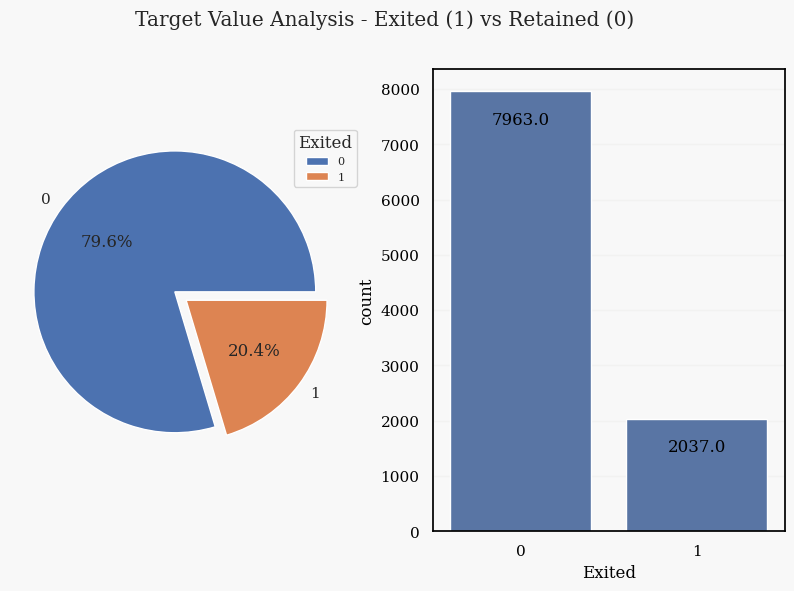

In [362]:
f,ax=plt.subplots(1,2,figsize=(10,6))

labels = data['Exited'].value_counts().index
sizes = data['Exited'].value_counts().values
explode = (0.1, 0) 

ax[0].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%')
ax[0].set_ylabel('') 
ax[0].legend(loc='upper right', title='Exited', fontsize=8)

sns.countplot(x='Exited', data=data, ax=ax[1])
for p in ax[1].patches:
    ax[1].annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='black', size=12)


plt.suptitle('Target Value Analysis - Exited (1) vs Retained (0)')

plt.show()

#### Categorical Variables Analysis

In [363]:
unique_values = data.nunique()
threshold = 12

continuous_features = data.nunique()[data.nunique() > threshold].index.tolist()
categorical_features = data.nunique()[data.nunique() <= threshold].index.tolist()

print(f"Continuous features: {continuous_features}")
print(f"Category features: {categorical_features}")

categorical_features.remove('Exited')


Continuous features: ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
Category features: ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']


/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_2288/3143761988.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column,data=data,ax=ax[1], palette='pastel')


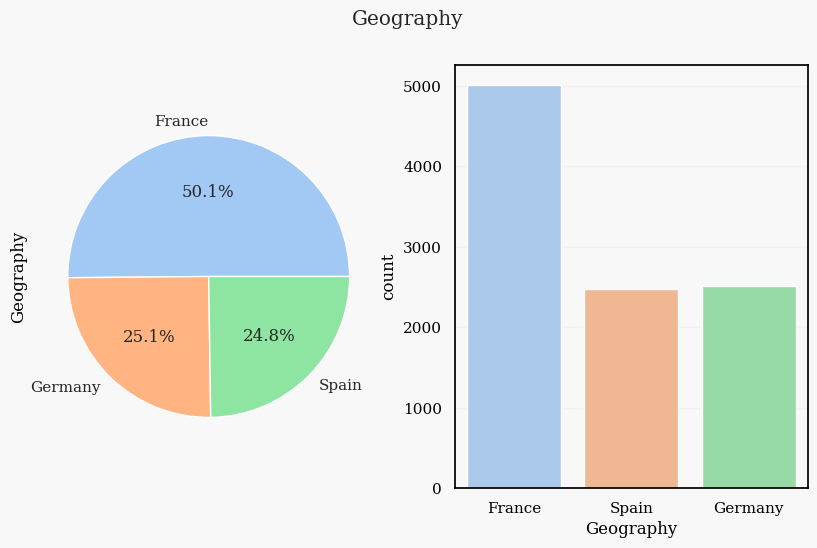

/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_2288/3143761988.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column,data=data,ax=ax[1], palette='pastel')


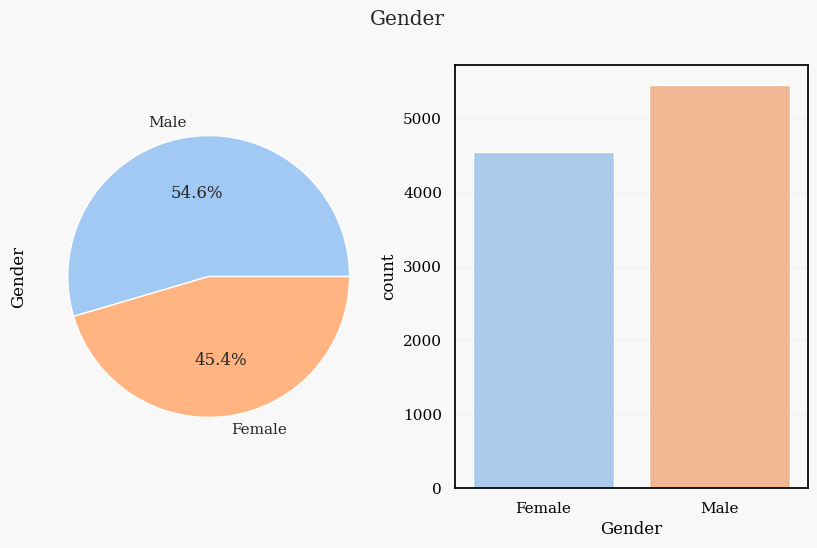

/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_2288/3143761988.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column,data=data,ax=ax[1], palette='pastel')


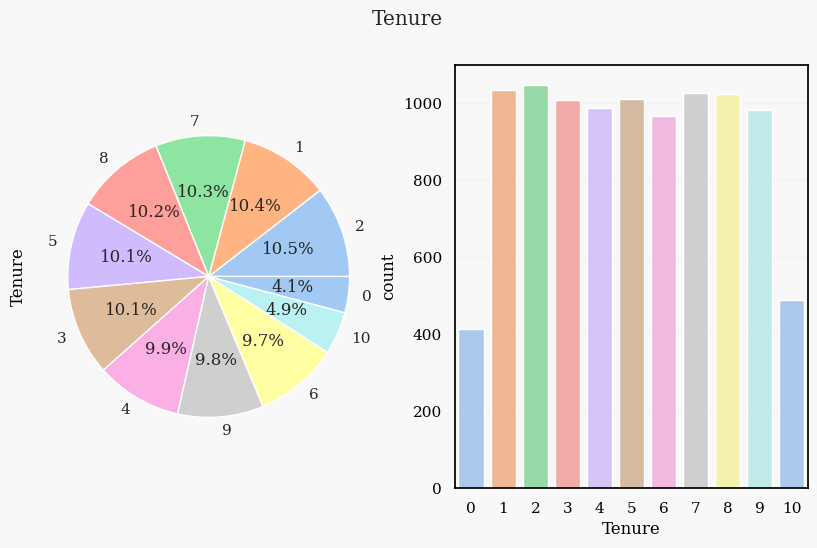

/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_2288/3143761988.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column,data=data,ax=ax[1], palette='pastel')


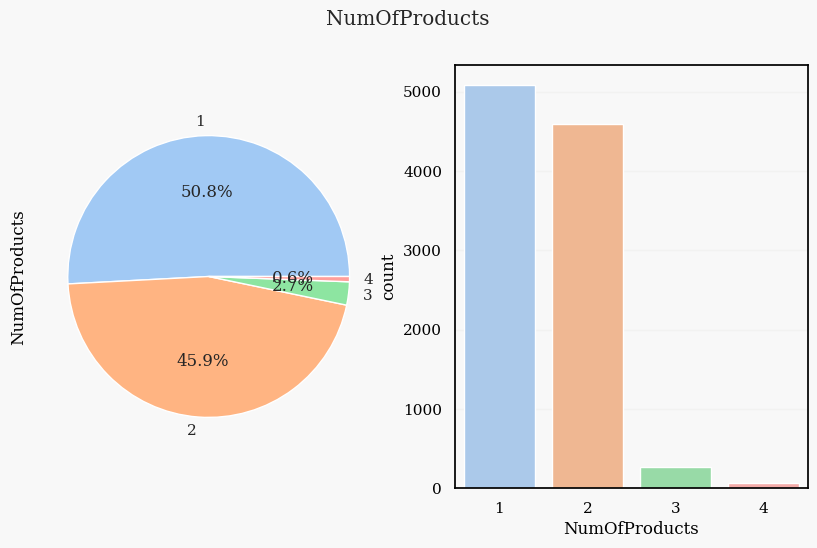

/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_2288/3143761988.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column,data=data,ax=ax[1], palette='pastel')


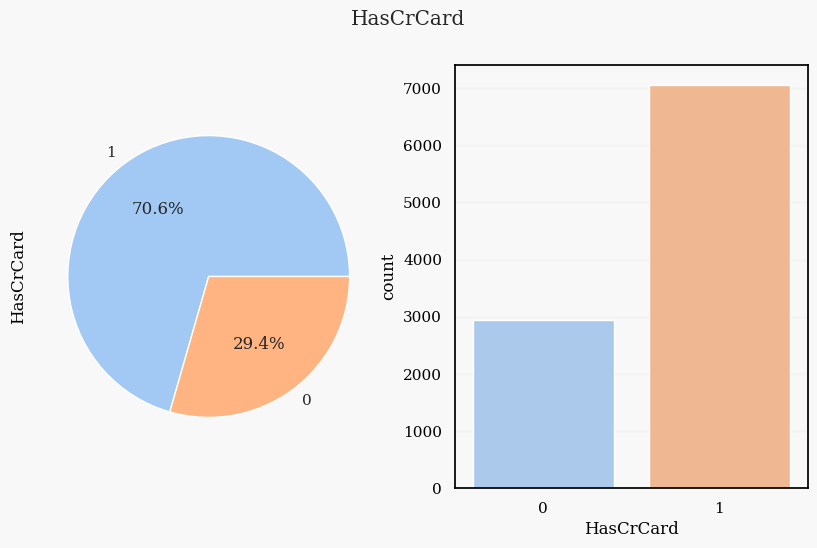

/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_2288/3143761988.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column,data=data,ax=ax[1], palette='pastel')


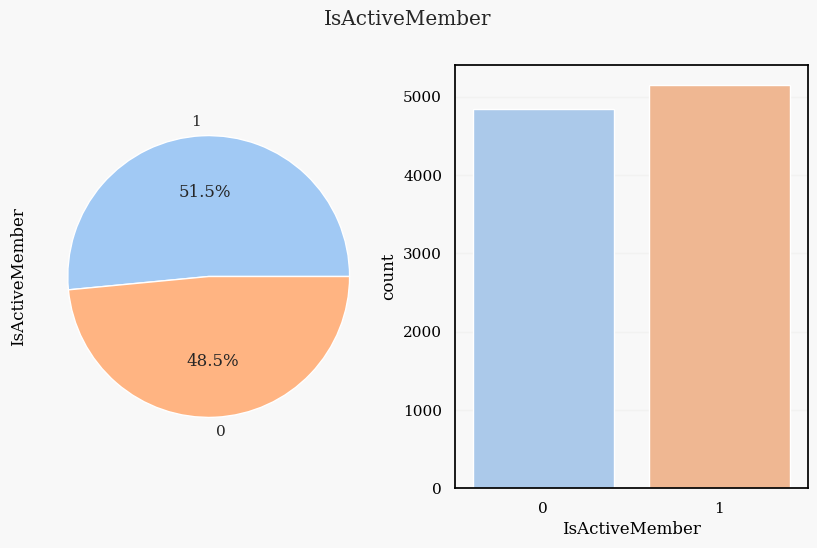

In [364]:
for column in categorical_features:
    f,ax=plt.subplots(1,2,figsize=(10,5.5))
    data[column].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0], colors =sns.color_palette('pastel'))
    ax[0].set_ylabel(f'{column}')
    sns.countplot(x=column,data=data,ax=ax[1], palette='pastel')
    plt.suptitle(f'{column}')
    plt.show()

#### Numerical Value Analysis

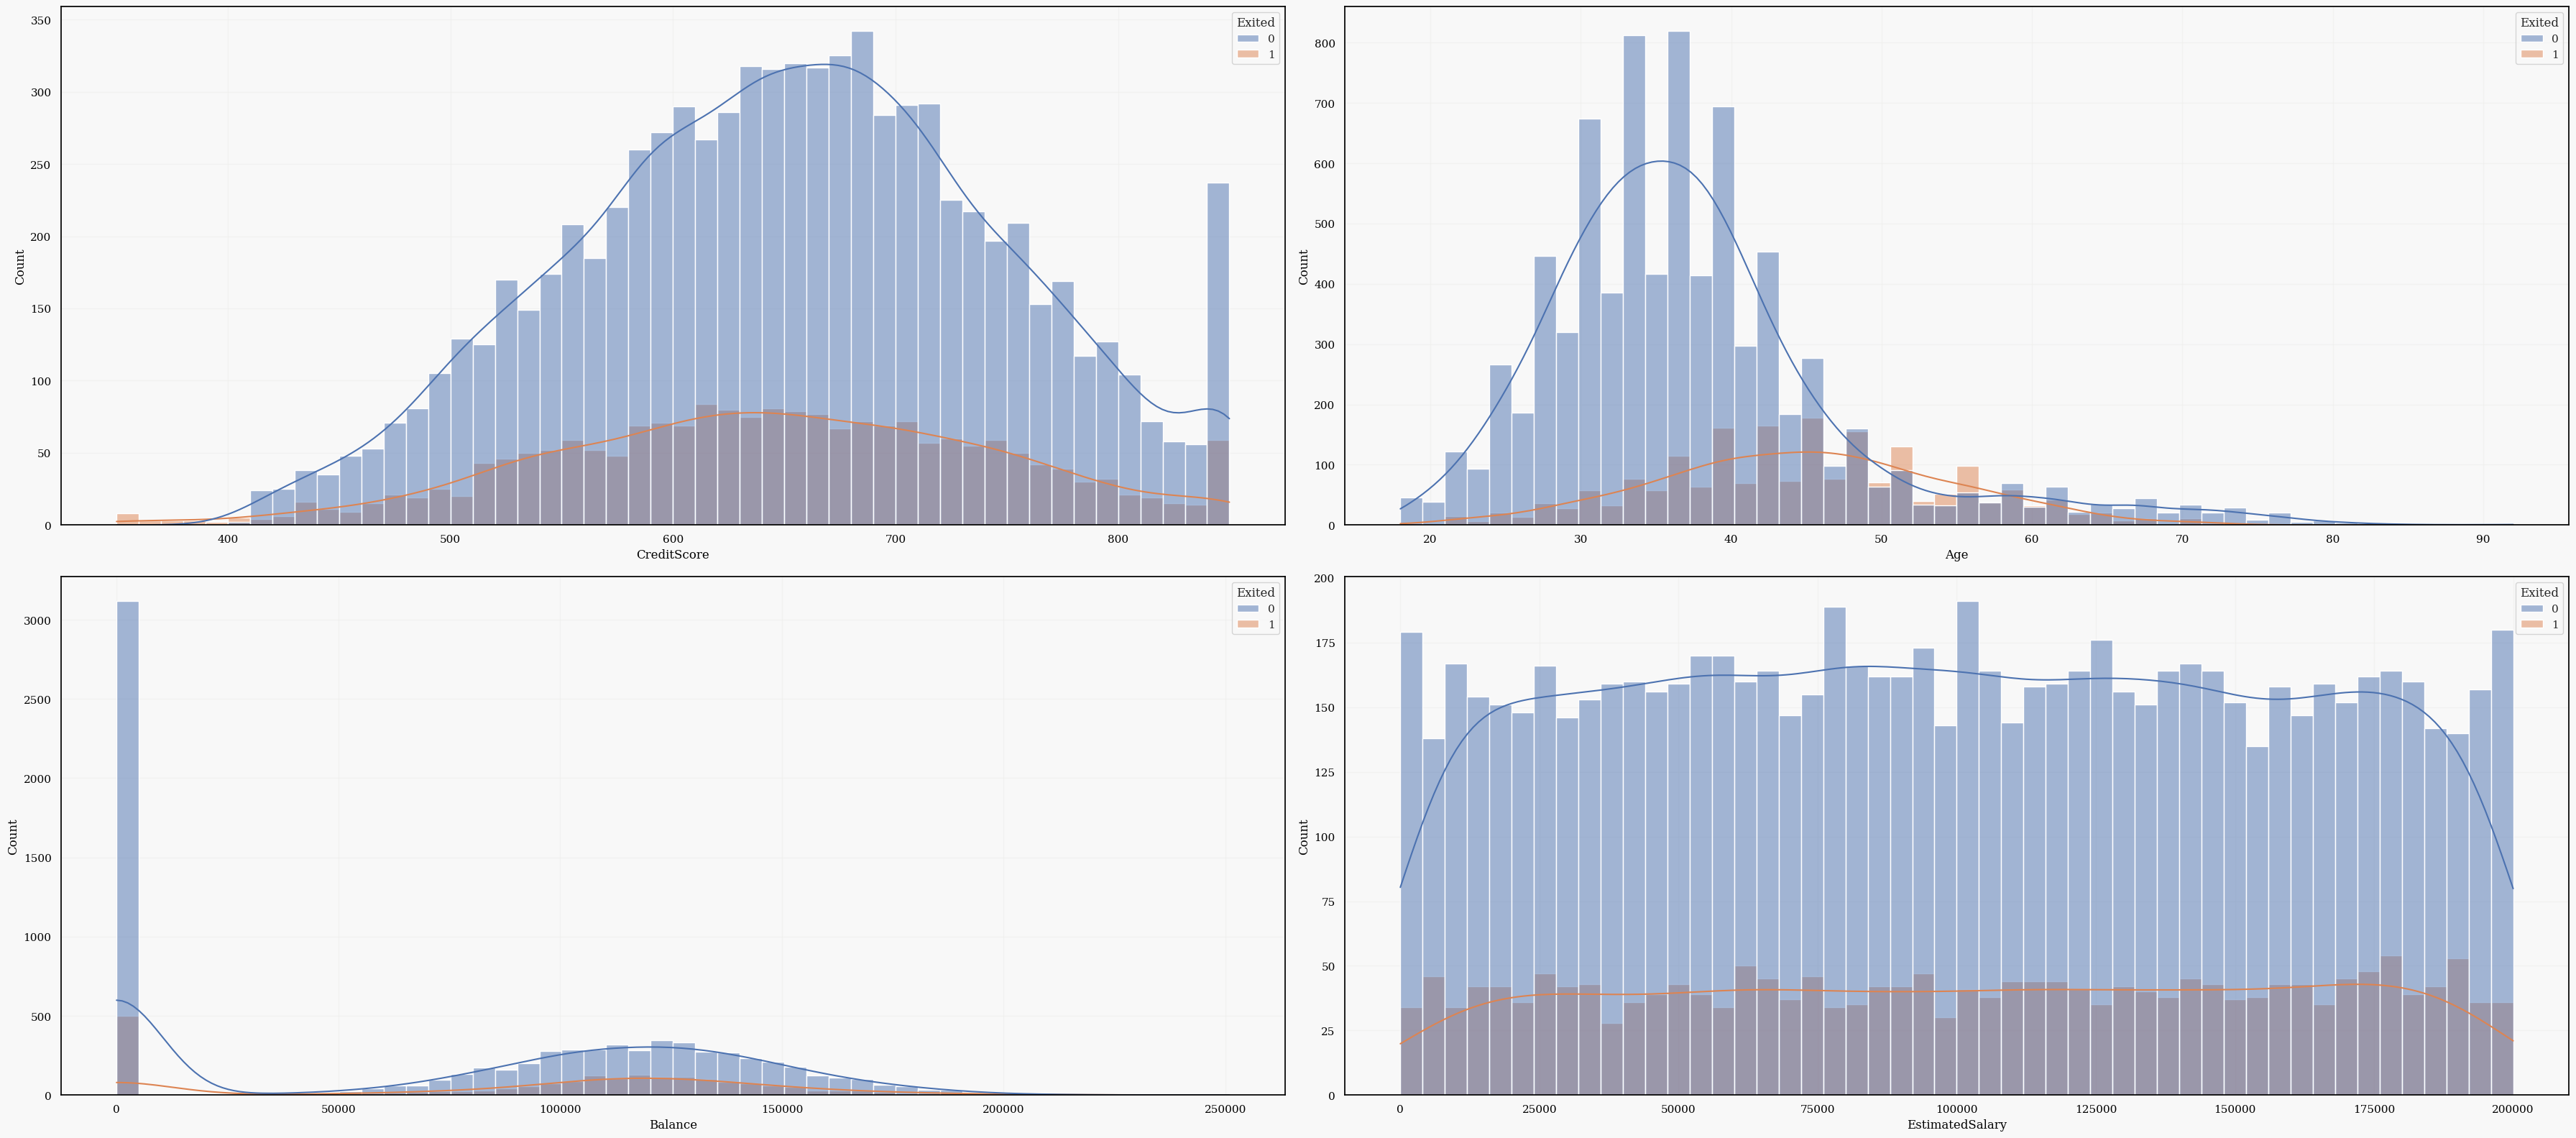

In [365]:
n_rows = (len(continuous_features) + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(36, 8 * n_rows))
axes = axes.flatten()

for i, column in enumerate(continuous_features):
    sns.histplot(data=data, x=column, hue="Exited", bins=50, kde=True, ax=axes[i])

if len(continuous_features) % 2 != 0:
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [366]:
data.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

#### Correlation Analysis


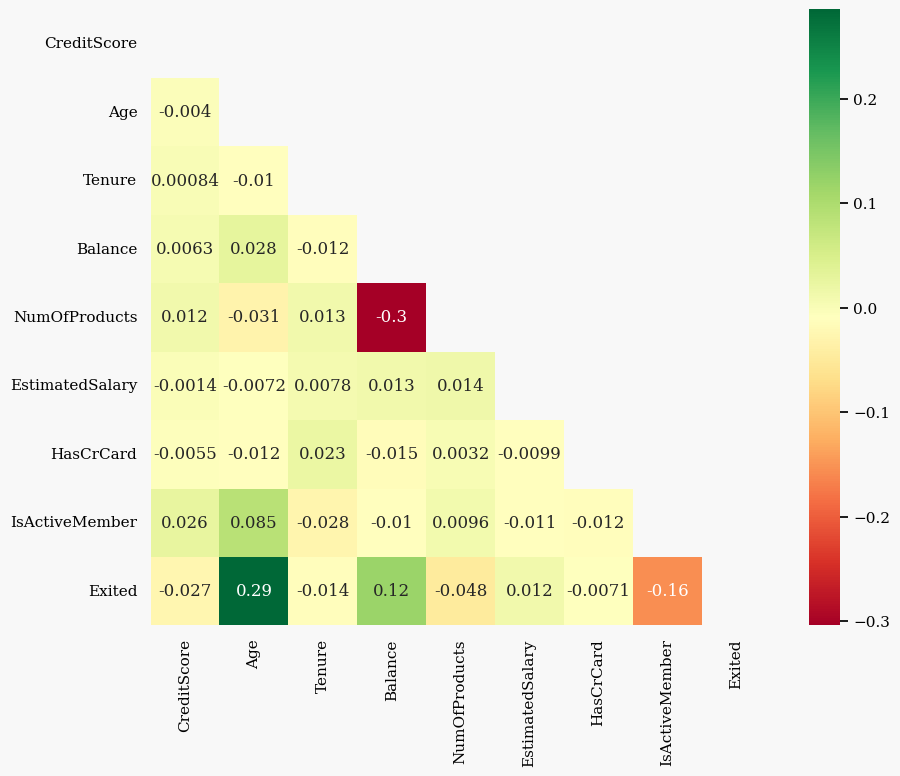

In [367]:
data4 = data[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'HasCrCard', 'IsActiveMember', 'Exited']].copy()
correlation = data4.corr()

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, mask=mask, annot=True, cmap='RdYlGn')
plt.show()






In [368]:
categorical_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
num_cols = ['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'EstimatedSalary']
target = 'Exited'


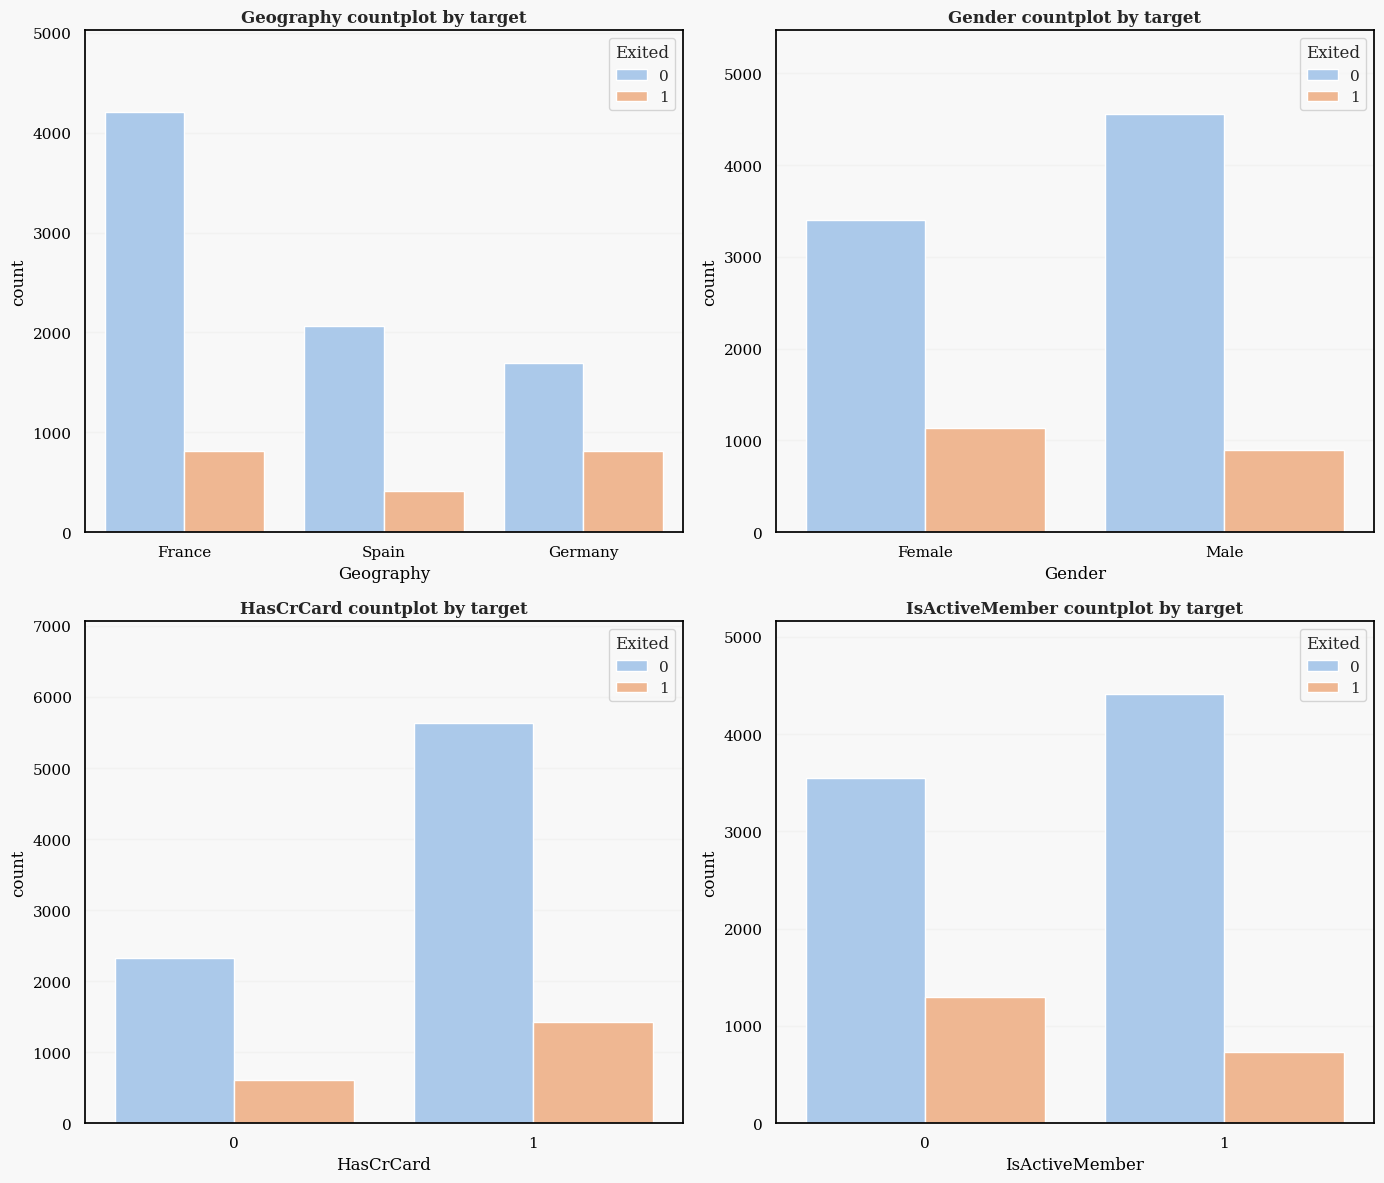

In [369]:
plt.figure(figsize=(14, len(categorical_cols)*3))

for i, col in enumerate(categorical_cols):
    
    plt.subplot(len(categorical_cols)//2 + len(categorical_cols) % 2, 2, i+1)
    sns.countplot(x=col, hue=target, data=data, palette='pastel')
    plt.title(f"{col} countplot by target", fontweight = 'bold')
    plt.ylim(0, data[col].value_counts().max() + 10)
    
plt.tight_layout()
plt.show()

In [370]:
data.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

#### Encoding categorical variables using one-hot encoding 


In [371]:
data_enc = pd.get_dummies(data, columns=['Geography', 'Gender'], drop_first=True, dtype='int64') 


In [372]:
data_enc.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


#### Feature Scaling

In [373]:
scaler = StandardScaler()
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
# numerical_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [374]:
data_enc[numerical_features] = scaler.fit_transform(data_enc[numerical_features])

In [375]:
data_enc.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,1,0,0,0
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,0,0,1,0
2,-1.536794,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,1,0,0,0
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,0,0,0,0
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,0,0,1,0


#### Function for generalization error

In [376]:
# def evaluate_classifier(classifier, X, y, cv_folds=5, scoring_method='accuracy'):

#     # Calculate the cross-validation score
#     cv_scores = cross_val_score(classifier, X, y, cv=cv_folds, scoring=scoring_method)
#     print(f"Cross-validation scores: {cv_scores}")

#     # Calculate the mean cross-validation score
#     cv_score_mean = cv_scores.mean()
#     print(f"Mean Cross-validation score: {cv_score_mean}")

#     # Calculate the standard deviation of the cross-validation scores
#     cv_score_std = cv_scores.std()
#     print(f"Standard Deviation of Cross-validation scores: {cv_score_std}")

#     # Calculate the generalization error
#     generalization_error = 1 - cv_score_mean
#     print(f"Generalization Error: {generalization_error}")

#     # Calculate the 95% confidence interval
#     confidence_interval = (cv_score_mean - 2 * cv_score_std, cv_score_mean + 2 * cv_score_std)
#     print(f"95% Confidence Interval: {confidence_interval}")

#     return cv_scores, cv_score_mean, cv_score_std, generalization_error, confidence_interval

In [377]:
def evaluate_classifier(classifier, X, y, cv_folds=5, scoring_method='accuracy'):
    # Create a pipeline that includes the SMOTE oversampling and the classifier
    # Note: This assumes that SMOTE or any other resampling should be part of the classifier's training process
    pipeline = make_pipeline_imblearn(SMOTE(random_state=42), classifier)

    # Define the cross-validation strategy and scoring
    stratified_kfold = StratifiedKFold(n_splits=cv_folds)
    scoring = make_scorer(accuracy_score) if scoring_method == 'accuracy' else scoring_method

    # Calculate the cross-validation scores using the pipeline
    cv_scores = cross_val_score(pipeline, X, y, cv=stratified_kfold, scoring=scoring)
    print(f"Cross-validation scores: {cv_scores}")

    # Calculate the mean and standard deviation of the cross-validation scores
    cv_score_mean = cv_scores.mean()
    cv_score_std = cv_scores.std()
    print(f"Mean Cross-validation score: {cv_score_mean}")
    print(f"Standard Deviation of Cross-validation scores: {cv_score_std}")

    # Calculate the generalization error as 1 - mean CV score
    generalization_error = 1 - cv_score_mean
    print(f"Generalization Error: {generalization_error}")

    # Calculate the 95% confidence interval for the CV scores
    confidence_interval = (cv_score_mean - 1.96 * cv_score_std, cv_score_mean + 1.96 * cv_score_std)
    print(f"95% Confidence Interval: {confidence_interval}")

    return cv_scores, cv_score_mean, cv_score_std, generalization_error, confidence_interval

In [378]:
def plot_auc_roc_curve(classifier, X_test, y_test):
    # Check if the classifier has a predict_proba method
    if hasattr(classifier, "predict_proba"):
        y_pred_prob = classifier.predict_proba(X_test)[:, 1]
    elif hasattr(classifier, "decision_function"):  # Use decision_function as a fallback
        y_pred_prob = classifier.decision_function(X_test)
    else:
        raise ValueError("Classifier does not have a predict_proba or a decision_function method.")
    
    # Calculate FPR, TPR, and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


#### Classification using Random Forest

Accuracy: 0.8645
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.78      0.46      0.58       407

    accuracy                           0.86      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.86      0.86      0.85      2000

Overall F1 score: 0.850387117398385


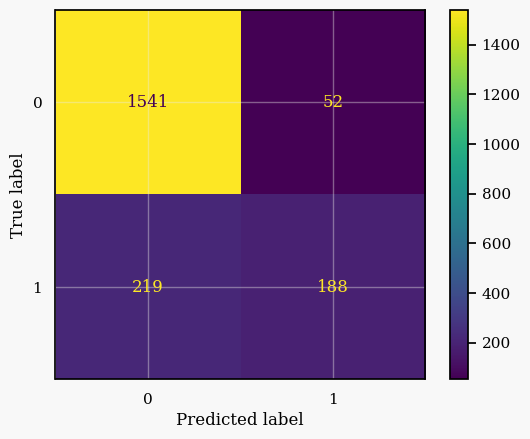

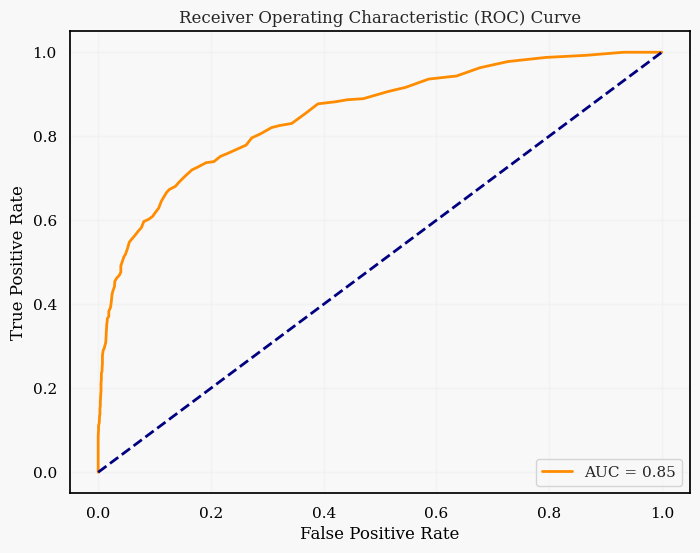

Cross-validation scores: [0.862  0.8715 0.859  0.865  0.8615]
Mean Cross-validation score: 0.8638000000000001
Standard Deviation of Cross-validation scores: 0.004296510211788185
Generalization Error: 0.13619999999999988
95% Confidence Interval: (0.8552069795764238, 0.8723930204235765)


In [379]:
X = data_enc.drop('Exited', axis=1)
y = data_enc['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))


# Overall F1 score
f1_score = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
print(f"Overall F1 score: {f1_score}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier.classes_)
disp.plot()
plt.show()

# Plot the ROC curve
plot_auc_roc_curve(rf_classifier, X_test, y_test)

# Calculate cv scores, generalization error without using evaluate_classifer function and SMOTE
cv_scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")

cv_score_mean = cv_scores.mean()
print(f"Mean Cross-validation score: {cv_score_mean}")

cv_score_std = cv_scores.std()
print(f"Standard Deviation of Cross-validation scores: {cv_score_std}")

generalization_error = 1 - cv_score_mean
print(f"Generalization Error: {generalization_error}")

confidence_interval = (cv_score_mean - 2 * cv_score_std, cv_score_mean + 2 * cv_score_std)
print(f"95% Confidence Interval: {confidence_interval}")







In [296]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define a parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt'],
    'criterion': ['gini', 'entropy', 'log_loss']
}

# Initialize a Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# # Fit GridSearchCV to the training data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and the best model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # Evaluate the best model on the test set
# best_model_accuracy = best_model.score(X_test, y_test)
# print(f"Best Model Accuracy: {best_model_accuracy}")
# print(f"Best Parameters: {best_params}")


Accuracy: 0.8665
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.81      0.45      0.58       407

    accuracy                           0.87      2000
   macro avg       0.84      0.71      0.75      2000
weighted avg       0.86      0.87      0.85      2000

Overall F1 score: 0.8510017904472881


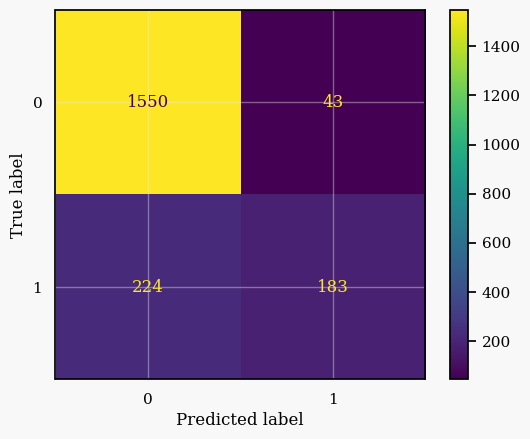

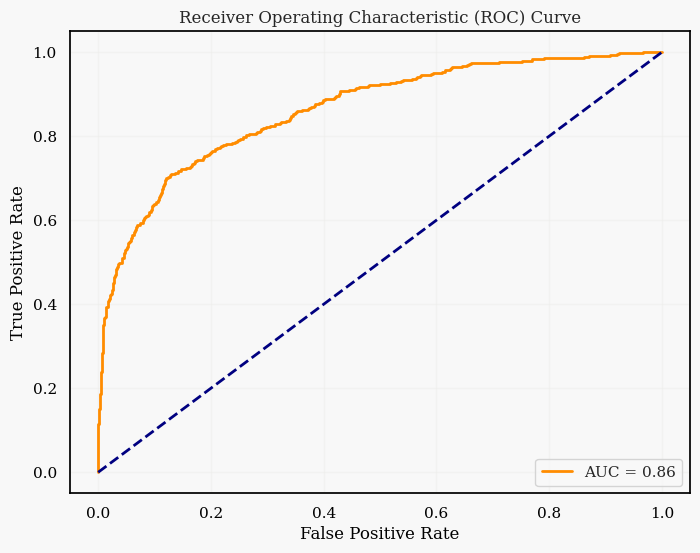

Cross-validation scores: [0.862  0.873  0.861  0.8695 0.8565]
Mean Cross-validation score: 0.8644000000000001
Standard Deviation of Cross-validation scores: 0.005994997914928746
Generalization Error: 0.13559999999999994
95% Confidence Interval: (0.8524100041701426, 0.8763899958298575)


In [380]:
# Best Parameters: {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}

rf_classifier_best_fit = RandomForestClassifier(n_estimators=200, 
                                                    criterion='entropy',
                                                    max_depth=30,
                                                    max_features='log2',
                                                    min_samples_leaf=4,
                                                    min_samples_split=10,
                                                    random_state=42)
rf_classifier_best_fit.fit(X_train, y_train)

y_pred = rf_classifier_best_fit.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Overall F1 score
f1_score = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
print(f"Overall F1 score: {f1_score}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier_best_fit.classes_)
disp.plot()
plt.show()

# Plot the ROC curve
plot_auc_roc_curve(rf_classifier_best_fit, X_test, y_test)

# Calculate cv scores, generalization error without using evaluate_classifer function and SMOTE
cv_scores = cross_val_score(rf_classifier_best_fit, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")

cv_score_mean = cv_scores.mean()
print(f"Mean Cross-validation score: {cv_score_mean}")

cv_score_std = cv_scores.std()
print(f"Standard Deviation of Cross-validation scores: {cv_score_std}")

generalization_error = 1 - cv_score_mean
print(f"Generalization Error: {generalization_error}")

confidence_interval = (cv_score_mean - 2 * cv_score_std, cv_score_mean + 2 * cv_score_std)
print(f"95% Confidence Interval: {confidence_interval}")

In [351]:
# Using SMOTE for class balancing
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)
balance_check = y_balanced.value_counts()
print(balance_check)

Exited
1    6370
0    6370
Name: count, dtype: int64


#### Random Forest after balancing data

Accuracy: 0.831
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89      1593
           1       0.58      0.61      0.59       407

    accuracy                           0.83      2000
   macro avg       0.74      0.75      0.74      2000
weighted avg       0.83      0.83      0.83      2000

F1 Score: 0.59


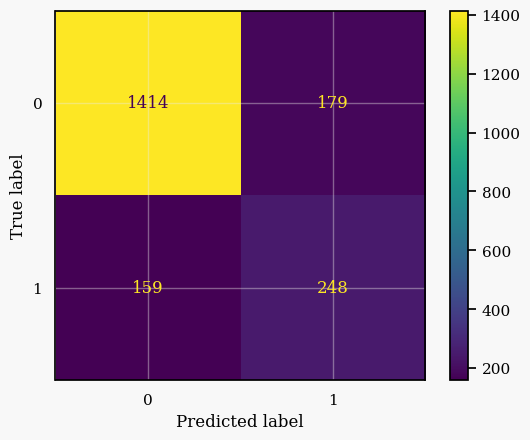

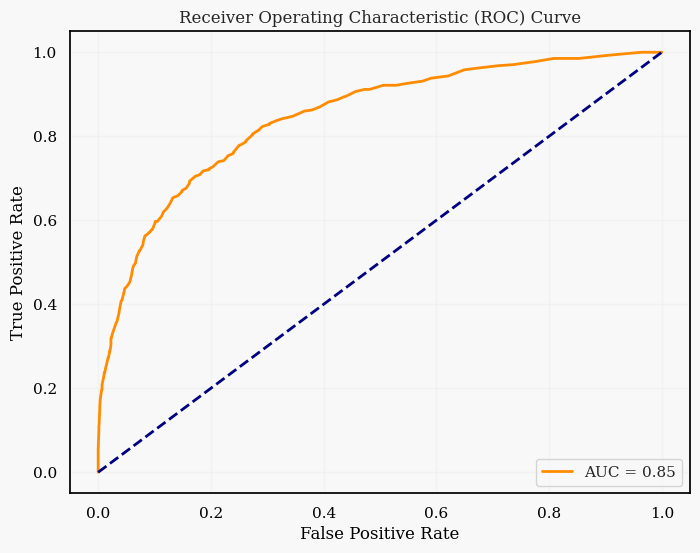

Cross-validation scores: [0.837  0.8255 0.826  0.837  0.8185]
Mean Cross-validation score: 0.8288
Standard Deviation of Cross-validation scores: 0.007201388754955518
Generalization Error: 0.17120000000000002
95% Confidence Interval: (0.8146852780402871, 0.8429147219597128)


In [352]:
rf_classifier_smote = RandomForestClassifier(
    n_estimators=100, 
    criterion='entropy',
    max_depth=30,
    max_features='log2',
    min_samples_leaf=1,
    # min_samples_split=1,
    random_state=42
)

rf_classifier_smote.fit(X_balanced, y_balanced)
y_pred = rf_classifier_smote.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Overall F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {round(f1,2)}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier.classes_)
disp.plot()
plt.show()

# Plot the ROC curve
plot_auc_roc_curve(rf_classifier_smote, X_test, y_test)

cv_scores, cv_score_mean, cv_score_std, generalization_error, confidence_interval = evaluate_classifier(rf_classifier_smote, X, y)



In [300]:
# Fit GridSearchCV to the balanced data
# grid_search.fit(X_balanced, y_balanced)

# # Get the best parameters and the best model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # Evaluate the best model on the test set
# best_model_accuracy = best_model.score(X_test, y_test)
# print(f"Best Model Accuracy: {best_model_accuracy}")
# print(f"Best Parameters: {best_params}")

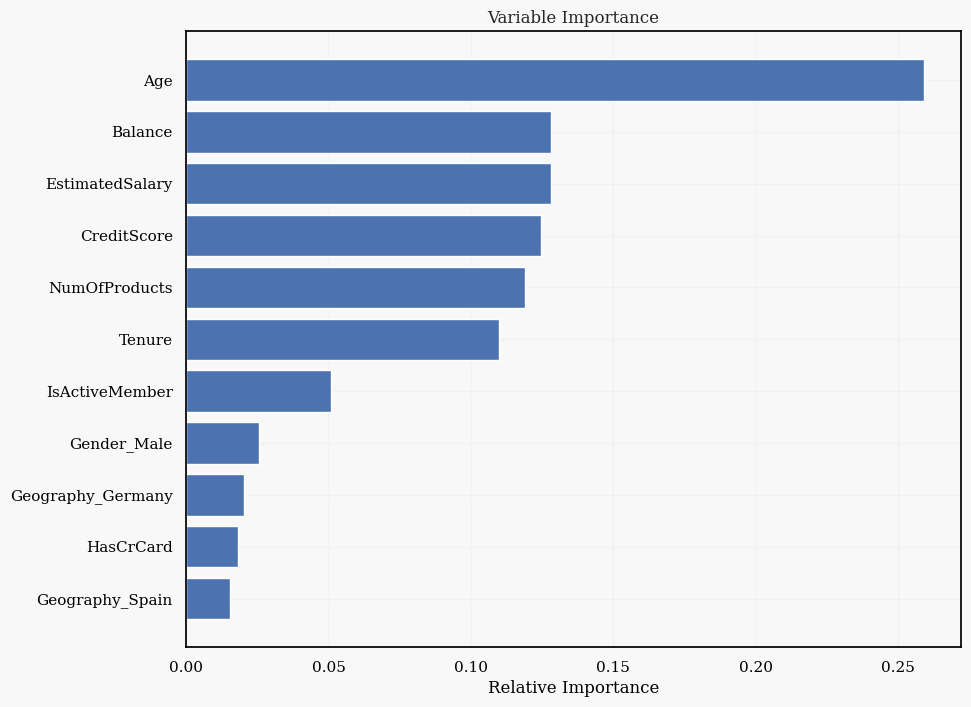

In [301]:
# Feature Importance
feature_importance = rf_classifier_smote.feature_importances_
# feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .05
plt.figure(figsize=(10, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


Exited
0    6370
1    6084
Name: count, dtype: int64
Accuracy: 0.8275
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      1593
           1       0.57      0.63      0.60       407

    accuracy                           0.83      2000
   macro avg       0.74      0.75      0.74      2000
weighted avg       0.83      0.83      0.83      2000



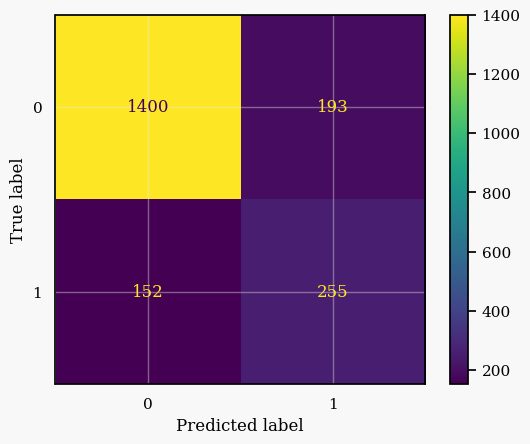

In [302]:
# Use ADASYN for class balancing
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

balance_check = y_adasyn.value_counts()
print(balance_check)

rf_classifier_adasyn = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42
)

rf_classifier_adasyn.fit(X_adasyn, y_adasyn)
y_pred = rf_classifier_adasyn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier.classes_)
disp.plot()
plt.show()



Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      1593
           1       0.62      0.55      0.58       407

    accuracy                           0.84      2000
   macro avg       0.75      0.73      0.74      2000
weighted avg       0.83      0.84      0.84      2000

F1 Score: 0.5822454308093994


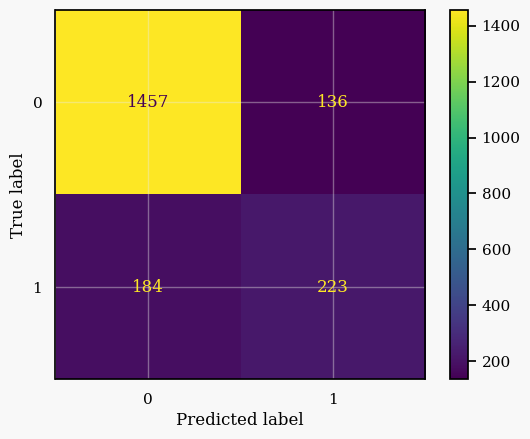

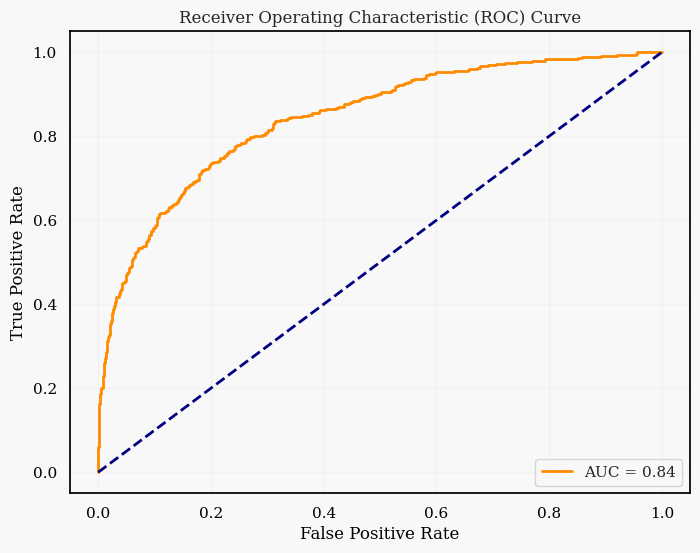

Cross-validation scores: [0.845  0.8545 0.8485 0.847  0.841 ]
Mean Cross-validation score: 0.8472
Standard Deviation of Cross-validation scores: 0.0044339598554790985
Generalization Error: 0.15280000000000005
95% Confidence Interval: (0.8385094386832609, 0.855890561316739)


In [303]:
# Use LightGBM model 
import lightgbm as lgb

lgb_classifier = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=30,
    num_leaves=1024,
    min_child_samples=10,
    random_state=42,
    verbose=-1
)

lgb_classifier.fit(X_balanced, y_balanced)
y_pred = lgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Overall F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lgb_classifier.classes_)
disp.plot()
plt.show()


# Plot the ROC curve
plot_auc_roc_curve(lgb_classifier, X_test, y_test)

cv_scores, cv_score_mean, cv_score_std, generalization_error, confidence_interval = evaluate_classifier(lgb_classifier, X, y)



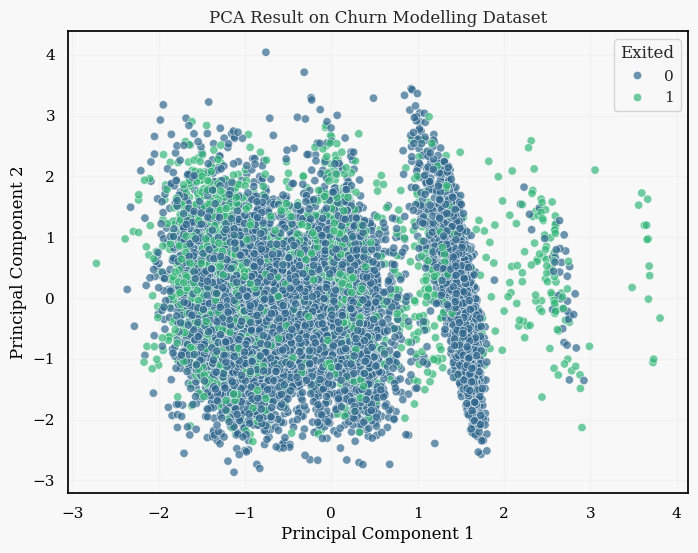

Explained variance by component: [0.18758508 0.14340851]


In [304]:
from sklearn.decomposition import PCA

# Applying PCA to reduce the features to 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Adding the reduced components to the original dataframe for visualization
data_enc['Principal Component 1'] = X_pca[:, 0]
data_enc['Principal Component 2'] = X_pca[:, 1]

# Now, let's visualize the PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='Principal Component 1', y='Principal Component 2', 
    hue='Exited', data=data_enc, palette='viridis', alpha=0.7
)
plt.title('PCA Result on Churn Modelling Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Exited')
plt.show()

print(f"Explained variance by component: {pca.explained_variance_ratio_}")


#### Classification on balanced data using SVM

Accuracy: 0.7885
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.81      0.86      1593
           1       0.49      0.70      0.57       407

    accuracy                           0.79      2000
   macro avg       0.70      0.75      0.72      2000
weighted avg       0.83      0.79      0.80      2000

F1 Score: 0.5731584258324924


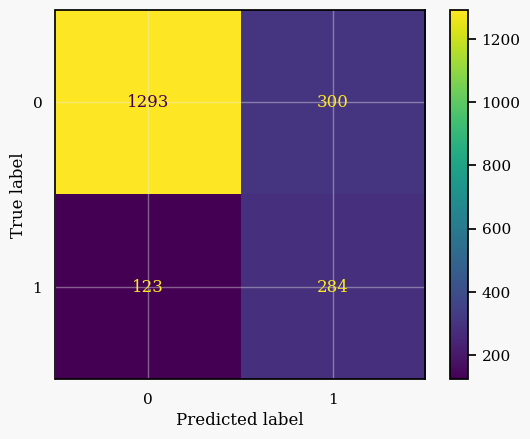

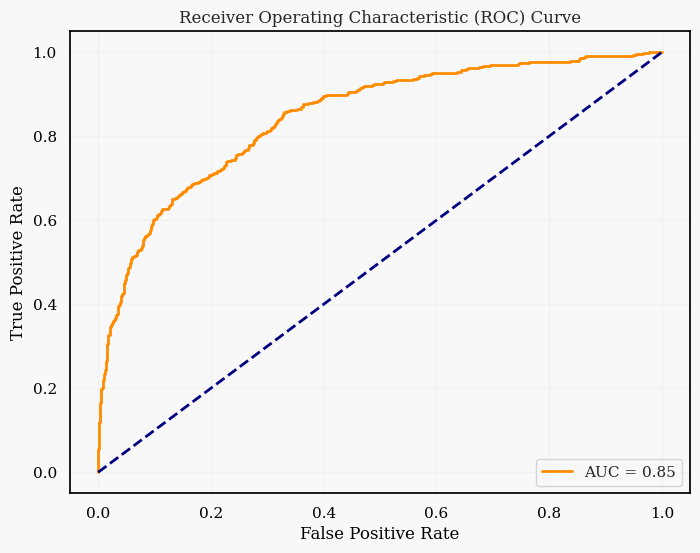

In [305]:
# Apply SVM for classification
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create a pipeline with a StandardScaler and an SVM classifier
svm = make_pipeline(StandardScaler(), SVC(random_state=42))

# Fit the model on the balanced training data
svm.fit(X_balanced, y_balanced)

# Predict the target variable on the test data
y_pred = svm.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Overall F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier.classes_)
disp.plot()
plt.show()


# Plot the ROC curve
plot_auc_roc_curve(svm, X_test, y_test)

# cv_scores, cv_score_mean, cv_score_std, generalization_error, confidence_interval = evaluate_classifier(svm, X, y)



Accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89      1593
           1       0.59      0.53      0.56       407

    accuracy                           0.83      2000
   macro avg       0.74      0.72      0.73      2000
weighted avg       0.82      0.83      0.83      2000



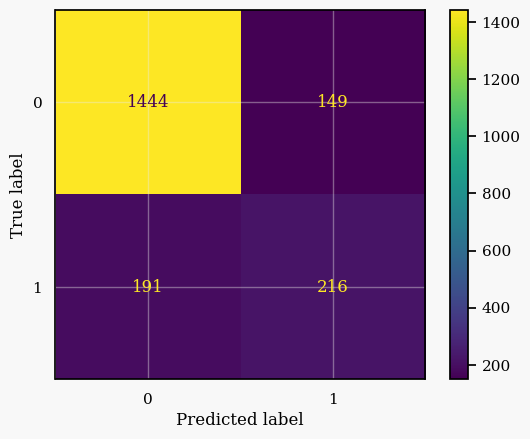

F1 Score: 0.5595854922279793


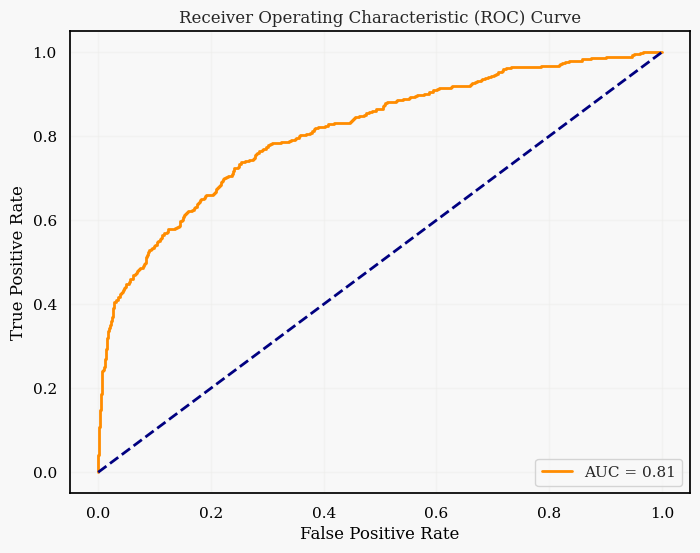

In [306]:
# Apply XGBoost for classification
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(
    n_estimators=300,
    max_depth=30,
    min_child_weight=10,
    random_state=42
)

xgb_classifier.fit(X_balanced, y_balanced)
y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier.classes_)
disp.plot()
plt.show()

# Overall F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# Plot the ROC curve
plot_auc_roc_curve(xgb_classifier, X_test, y_test)

# cv_scores, cv_score_mean, cv_score_std, generalization_error, confidence_interval = evaluate_classifier(xgb_classifier, X, y)





Accuracy: 0.7885
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.81      0.86      1593
           1       0.49      0.70      0.57       407

    accuracy                           0.79      2000
   macro avg       0.70      0.75      0.72      2000
weighted avg       0.83      0.79      0.80      2000



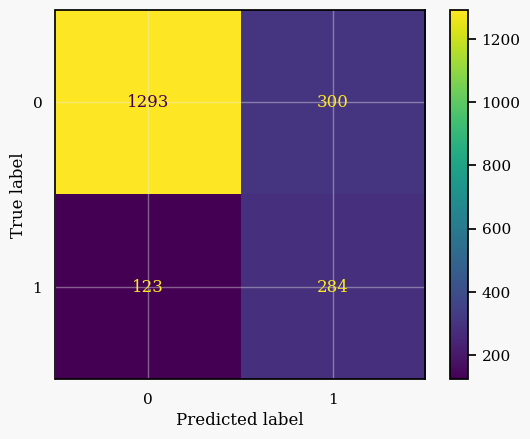

F1 Score: 0.5731584258324924


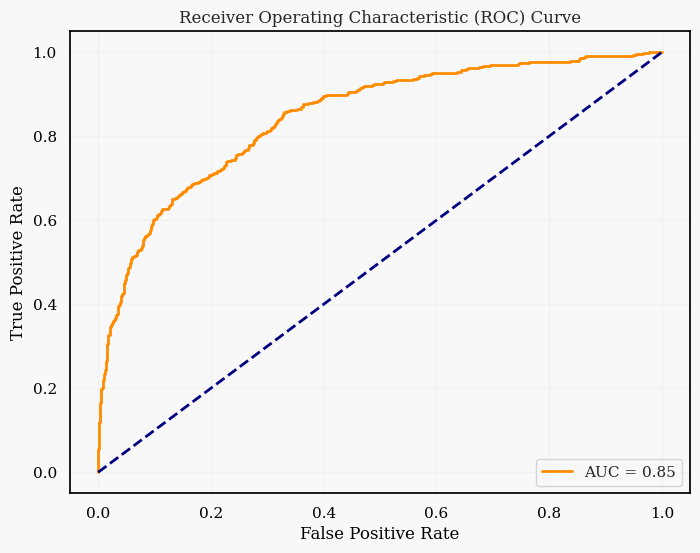

In [307]:
# Apply SVM with non-linear kernel
svm_rbf = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42))

# Fit the model on the balanced training data
svm_rbf.fit(X_balanced, y_balanced)

# Predict the target variable on the test data
y_pred = svm_rbf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier.classes_)
disp.plot()
plt.show()

# Overall F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# Plot the ROC curve
plot_auc_roc_curve(svm_rbf, X_test, y_test)

# cv_scores, cv_score_mean, cv_score_std, generalization_error, confidence_interval = evaluate_classifier(svm_rbf, X, y)

Accuracy: 0.8415
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      1593
           1       0.64      0.51      0.57       407

    accuracy                           0.84      2000
   macro avg       0.76      0.72      0.74      2000
weighted avg       0.83      0.84      0.83      2000



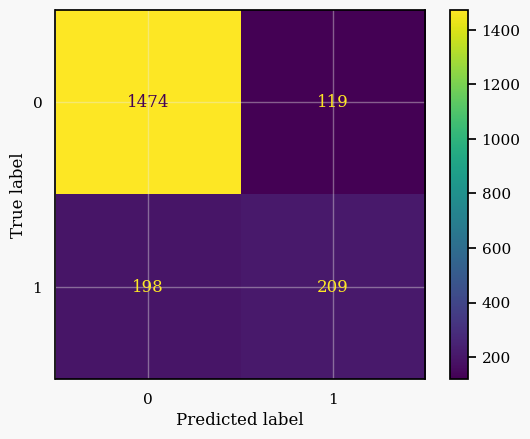

F1 Score: 0.5687074829931973


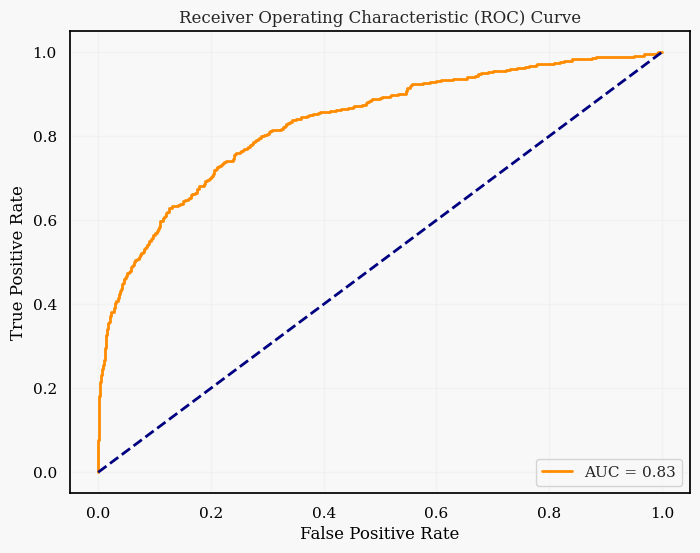

In [308]:
# Use CatBoost for classification
from catboost import CatBoostClassifier

catboost_classifier = CatBoostClassifier(
    eval_metric='AUC',
    iterations=7000,
    learning_rate=0.03,
    random_state=42,
    verbose=0
)

catboost_classifier.fit(X_balanced, y_balanced)
y_pred = catboost_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier.classes_)
disp.plot()
plt.show()

# Overall F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# Plot the ROC curve
plot_auc_roc_curve(catboost_classifier, X_test, y_test)

# cv_scores, cv_score_mean, cv_score_std, generalization_error, confidence_interval = evaluate_classifier(catboost_classifier, X, y)


In [309]:
pip install catboost


Note: you may need to restart the kernel to use updated packages.


#### Feature Engineering


In [310]:
# Customer Loyalty Index: A composite metric based on Tenure, NumOfProducts, and IsActiveMember. Customers with a longer tenure, more products, and active membership might be considered more loyal.
data['CustomerLoyaltyIndex'] = data['Tenure'] * data['NumOfProducts'] * data['IsActiveMember']

# Credit Score Bands: Group CreditScore into categories like high, medium, and low to capture risk profiles.
data['CreditScoreBand'] = pd.cut(data['CreditScore'], bins=[300, 600, 700, 850], labels=['Low', 'Medium', 'High'])

# Age Group: Group Age into meaningful categories such as young, adult, and senior which may correlate differently with churn.
data['AgeGroup'] = pd.cut(data['Age'], bins=[18, 30, 60, 90], labels=['Young', 'Adult', 'Senior'])

# Balance to Salary Ratio: This could indicate financial health or stress.
data['BalanceSalaryRatio'] = data['Balance'] / data['EstimatedSalary']

# Customer Value Score: A weighted sum of Balance and NumOfProducts can indicate the overall value of the customer to the bank.
data['CustomerValueScore'] = data['Balance'] * 0.6 + data['NumOfProducts'] * 0.4

data['SalaryBand'] = pd.cut(data['EstimatedSalary'], bins=[0, 50000, 100000, 150000, 200000], labels=['Low', 'Medium', 'High', 'Very High'])

data['IsWealthy'] = (data['Balance'] > data['Balance'].quantile(0.75)).astype(int)


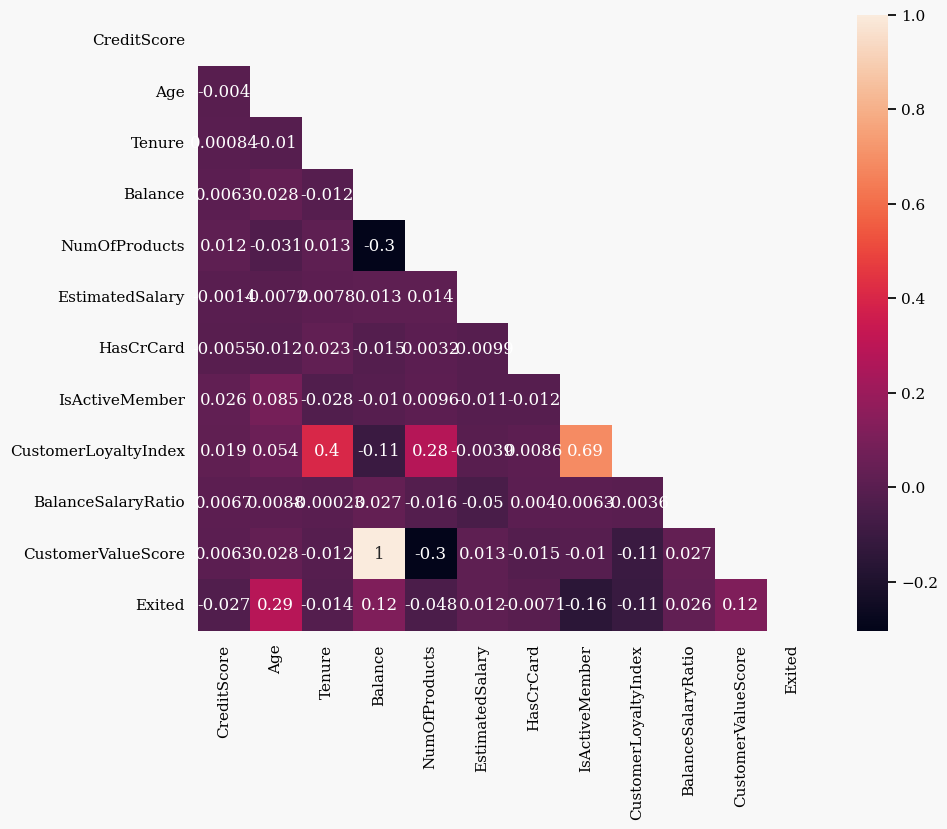

In [311]:
# plot correlation matrix
data5 = data[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'HasCrCard', 'IsActiveMember', 'CustomerLoyaltyIndex', 'BalanceSalaryRatio', 'CustomerValueScore' ,'Exited']].copy()
correlation = data5.corr()
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, mask=mask, annot=True)
plt.show()


In [314]:
# Drop Tenure and NumOfProducts from numerical features
numerical_features.remove('Tenure')
numerical_features.remove('NumOfProducts')
numerical_features

ValueError: list.remove(x): x not in list

In [315]:
numerical_features

['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [316]:
# Encoding categorical features
data_enc = pd.get_dummies(data, columns = ['Geography', 'Gender', 'CreditScoreBand', 'AgeGroup', 'SalaryBand', 'Tenure', 'NumOfProducts'], drop_first=True, dtype='int64')

# Standardizing numerical features
scaler = StandardScaler()
numerical_features.extend(['CustomerLoyaltyIndex', 'BalanceSalaryRatio', 'CustomerValueScore'])
print(numerical_features)
# numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'CustomerLoyaltyIndex', 'BalanceSalaryRatio', 'CustomerValueScore']

data_enc[numerical_features] = scaler.fit_transform(data_enc[numerical_features])



['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'CustomerLoyaltyIndex', 'BalanceSalaryRatio', 'CustomerValueScore']


In [262]:
features = ['AgeGroup_Adult', 'AgeGroup_Senior', 'Geography_Germany', 'Geography_Spain', 'Exited', 'CustomerLoyaltyIndex', 'BalanceSalaryRatio', 'CustomerValueScore', 'IsWealthy', 'Gender_Male', 'CreditScoreBand_Medium', 'CreditScoreBand_High', 'SalaryBand_Medium', 'SalaryBand_High',
       'SalaryBand_Very High']

In [263]:
# data_enc = data_enc[features]

Accuracy: 0.831
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      1593
           1       0.57      0.67      0.62       407

    accuracy                           0.83      2000
   macro avg       0.74      0.77      0.75      2000
weighted avg       0.84      0.83      0.84      2000



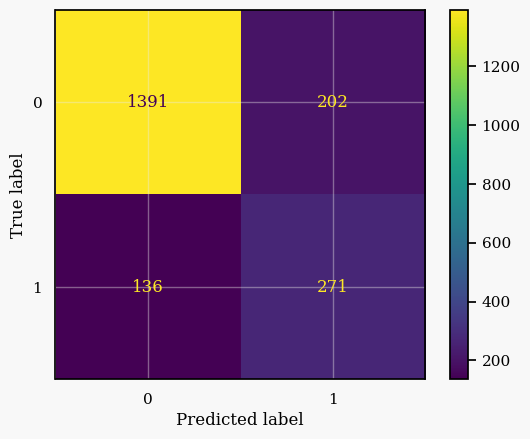

F1 Score: 0.6159090909090911


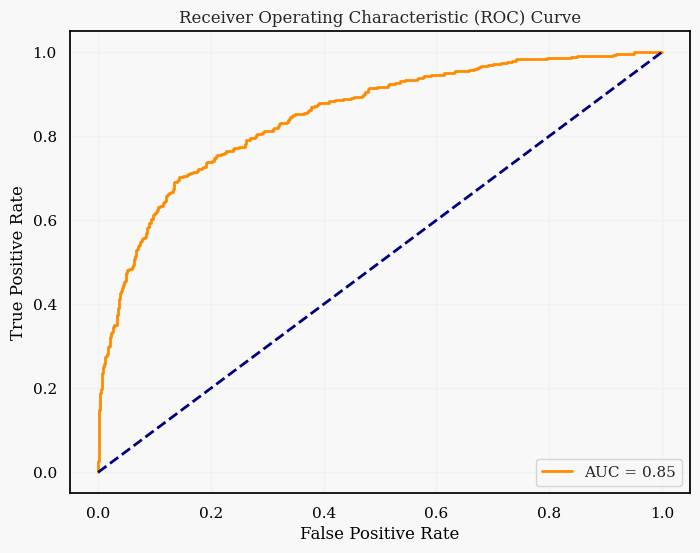

In [317]:


# Splitting the data into features and target variable
X = data_enc.drop('Exited', axis=1)
y = data_enc['Exited']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Balancing the training data using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)
# X_balanced, y_balanced = X_train, y_train

# Fitting the Random Forest model on the balanced training data
rf_classifier = RandomForestClassifier(n_estimators=200, max_depth=30, min_samples_split=10, min_samples_leaf=4, criterion='entropy', max_features='log2', random_state=42)
rf_classifier.fit(X_balanced, y_balanced)

# Predicting the target variable on the test data
y_pred = rf_classifier.predict(X_test)

# Calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Printing the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier.classes_)
disp.plot()
plt.show()

# Overall F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# Plot the ROC curve
plot_auc_roc_curve(rf_classifier, X_test, y_test)

# cv_scores, cv_score_mean, cv_score_std, generalization_error, confidence_interval = evaluate_classifier(rf_classifier, X, y)

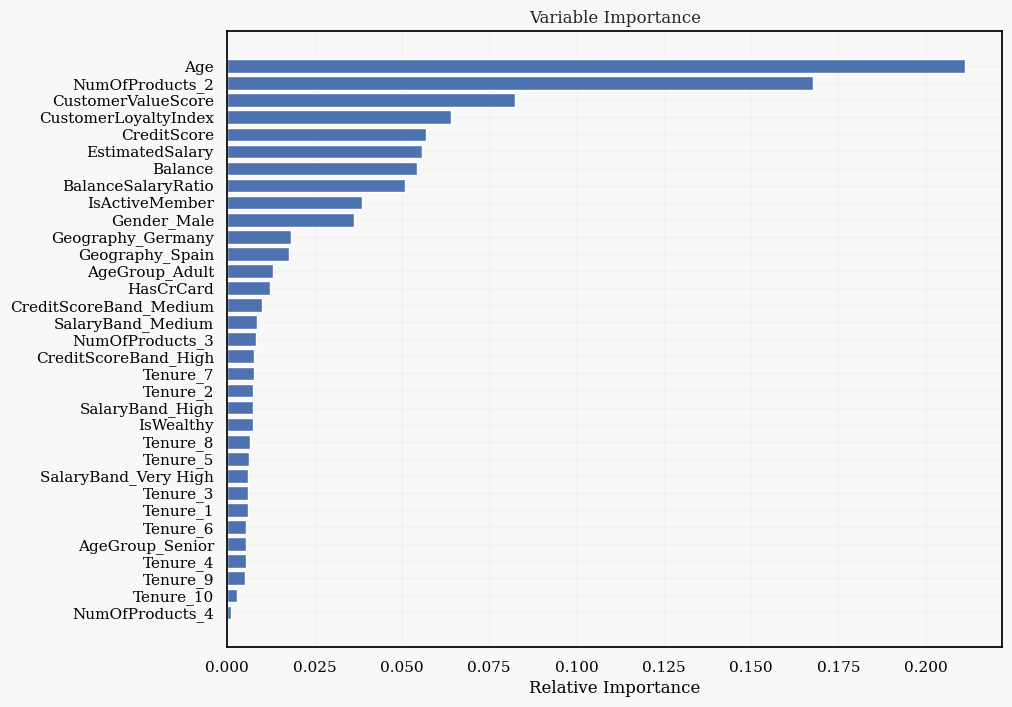

In [318]:
# Plot feature importance
feature_importance = rf_classifier.feature_importances_
# feature_importance = 100.0 * (feature_importance / feature_importance.max())

# plot the feature importance for better visualization
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .05
plt.figure(figsize=(10, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')   
plt.show()
